# Example: Testing simple colour cuts for glSNe Ia

Here we show one simple example for how JOLTEON can be used. One proposed method to identify glSNe is based on their colour (e.g. Quimby et al. 2014). Due to their higher redshifts, glSNe will overall appear redder at peak than an unlensed supernova with the same apparent magnitude. In this notebook we take advantage of the simulated unlensed SNe Ia from ELASTICC to show how they can help us identify lensed Ia SNe.

## Imports

In [1]:
import os
from glob import glob
import numpy as np
from astropy.table import Table


import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('./stylesheet/style.mplstyle')

In [2]:
# Path to the ELAsTiCC directory on Perlmutter
elasticc_path = '/global/cfs/cdirs/desc-td/ELASTICC2/'

#Name of directories within ELASTICC of the transients we are interested in
directories = {
    "glSN_Ia": "ELASTICC2_FINAL_SL-SN1a",
    "SNIa": "ELASTICC2_FINAL_SNIa-SALT3"
}

#For this example we will just focus on the magnitudes at peak, which are stored in the header files. Thus, we only need to access the header files
header_files = {}

for key, directory in directories.items():
    path = f"{elasticc_path}/{directory}"
    header_files[key] = sorted(glob(f"{path}/*HEAD*"))


In this example we will just look at the r-z colour and the z-band peak magnitude

In [3]:
# Initialize empty arrays
zmag = np.array([])
rz = np.array([])
glSN_id = np.array([]) #We save this to find whether multiple images of the same glSN pass the cuts

# Iterate over the lensed SNIa header files
for file in header_files['glSN_Ia']:
    t_header = Table.read(file)
    z_peak = np.array(t_header['SIM_PEAKMAG_z'])
    r_peak = np.array(t_header['SIM_PEAKMAG_r'])
    id_SN = np.array(t_header['SIM_STRONGLENS_IDLENS'])
    
    rz = np.concatenate((rz, r_peak - z_peak))
    zmag = np.concatenate((zmag, z_peak))
    glSN_id = np.concatenate((glSN_id, id_SN))

In [4]:
# Initialize empty arrays for unlensed SNIa
zmag_unlensed = np.array([])
rz_unlensed = np.array([])

# Iterate over the SNIa header files
for file in header_files['SNIa']:
    t_header = Table.read(file)
    z_peak_unlensed = np.array(t_header['SIM_PEAKMAG_z'])
    r_peak_unlensed = np.array(t_header['SIM_PEAKMAG_r'])
    
    rz_unlensed = np.concatenate((rz_unlensed, r_peak_unlensed - z_peak_unlensed))
    zmag_unlensed = np.concatenate((zmag_unlensed, z_peak_unlensed))
    

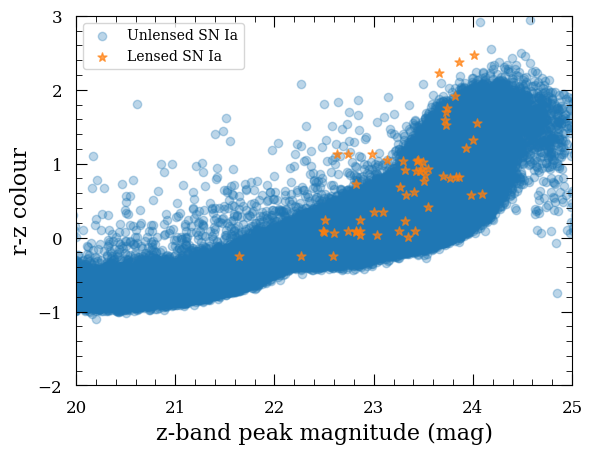

In [5]:
plt.figure()
plt.scatter(zmag_unlensed, rz_unlensed, alpha = 0.3, label = 'Unlensed SN Ia')
plt.scatter(zmag, rz,alpha = 0.7, label = 'Lensed SN Ia', marker = '*', s = 45)
plt.xlim(20,25)
plt.ylim(-2,3)
plt.xlabel('z-band peak magnitude (mag)')
plt.ylabel('r-z colour')
plt.legend()
plt.show()

In [6]:
#2D definitions of sigma-level contours

sigma10=1 - np.exp(-(1)**2/2)
sigma20=1 - np.exp(-(2)**2/2)
sigma30=1 - np.exp(-(3)**2/2)
sigma40=1 - np.exp(-(4)**2/2)
sigma50=1 - np.exp(-(5)**2/2)

In [7]:
# Draw a subsample of the unlensed supernova set (to allow for quicker results drawing seaborn contours)

indices = np.random.choice (len(zmag_unlensed), size = 50000)

z_unlensed_subset = zmag_unlensed[indices]
rz_unlensed_subset = rz_unlensed[indices]

We start by defining our cuts using the 3-sigma confidence contours

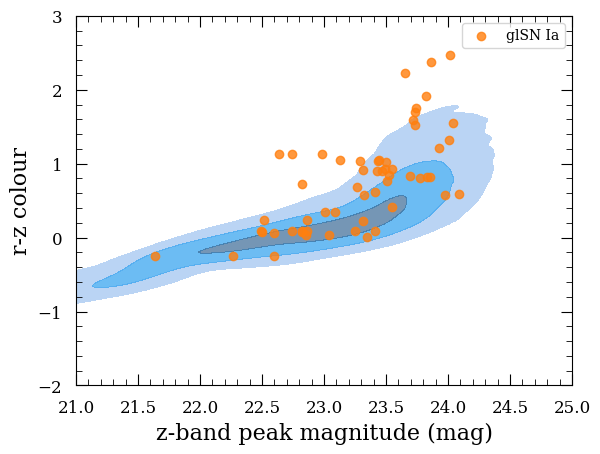

In [8]:
plt.figure()
colour_kde = sns.kdeplot(x=z_unlensed_subset, y=rz_unlensed_subset, levels = [1-sigma30, 1-sigma20, 1-sigma10, 1], fill=True, alpha = 0.7, label = 'SN Ia colour contours')
plt.scatter(zmag, rz, alpha = 0.8, label = 'glSN Ia')
plt.xlim(21,25)
plt.xlabel('z-band peak magnitude (mag)')
plt.ylabel('r-z colour')
plt.legend()
plt.ylim(-2,3)
plt.show()

In [ ]:
colourcuts_contours = colour_kde.collections[0].get_paths()

# Function to check if a point is inside any contour
def is_inside_contours(x, y, contours):
    for contour in contours:
        if contour.contains_point((x, y)):
            return True
    return False

# Flag points outside the contours - these lightcurves pass our colour cuts
detected_lc = [not is_inside_contours(x, y, colourcuts_contours) for x, y in zip(zmag, rz)]
undetected_lc = [is_inside_contours(x, y, colourcuts_contours) for x, y in zip(zmag, rz)]

# Plot the points and contours and distinguish those with 
plt.scatter(np.array(zmag)[undetected_lc], np.array(rz)[undetected_lc], label='Undetected glSN images', alpha = 0.8)
plt.scatter(np.array(zmag)[detected_lc], np.array(rz)[detected_lc], marker = '*', label='Detected glSN images')
sns.kdeplot(x=z_unlensed_subset, y=rz_unlensed_subset, levels = [1-sigma30, 1-sigma20, 1-sigma10, 1], fill=False, alpha = 0.7)
plt.xlim(21,25)
plt.ylim(-2,3)
plt.legend()
plt.xlabel('z-band peak magnitude (mag)')
plt.ylabel('r-z colour')
plt.show()

SN_id_detected = glSN_id[detected_lc]
percentage = len(np.unique(SN_id_detected))/len(np.unique(glSN_id))*100

print('Our method detected %s images, out of which %s corresponded to individual glSNe. This means %.2f percent of our original glSNe Ia have been detected with this method.' %(len(SN_id_detected), len(np.unique(SN_id_detected)),
                                                                                                                                                                percentage))

This method has two main challenges. The first one is the low true positive rate, at 21%, meaning a lot of glSNe will still be missed. The second challenge is especially relevant in the era of wide-field deep surveys: the false positive rate. Most detections will still be unlensed supernovae that fall outside the cuts. The FPR can be reduced by defining more stringent colour cuts, but this will come at the cost of less glSNe being detected.

In [ ]:
plt.figure()
colour_kde_5sigma = sns.kdeplot(x=z_unlensed_subset, y=rz_unlensed_subset, levels = [ 1-sigma50, 1-sigma40, 1-sigma30, 1-sigma20, 1-sigma10, 1], fill=True, alpha = 0.7, label = 'SN Ia colour contours')
plt.scatter(zmag, rz, alpha = 0.8, label = 'glSN Ia')
plt.xlim(21,25)
plt.ylim(-2,3)
plt.xlabel('z-band peak magnitude (mag)')
plt.ylabel('r-z colour')
plt.show()

In [ ]:
colourcuts_5sigmacontours = colour_kde_5sigma.collections[0].get_paths()

# Flag points outside the contours - these lightcurves pass our colour cuts
detected_lc_5sigma = [not is_inside_contours(x, y, colourcuts_5sigmacontours) for x, y in zip(zmag, rz)]
undetected_lc_5sigma = [is_inside_contours(x, y, colourcuts_5sigmacontours) for x, y in zip(zmag, rz)]

# Plot the points and contours and distinguish those with 
plt.scatter(np.array(zmag)[undetected_lc], np.array(rz)[undetected_lc], label='Undetected glSN images', alpha = 0.8)
plt.scatter(np.array(zmag)[detected_lc], np.array(rz)[detected_lc], marker = '*', label='Detected glSN images')
sns.kdeplot(x=z_unlensed_subset, y=rz_unlensed_subset, levels = [ 1-sigma50, 1-sigma40, 1-sigma30, 1-sigma20, 1-sigma10, 1], fill=False, alpha = 0.7)
plt.xlim(21,25)
plt.ylim(-2,3)
plt.legend()
plt.xlabel('z-band peak magnitude (mag)')
plt.ylabel('r-z colour')
plt.show()

SN_id_detected_5s = glSN_id[detected_lc_5sigma]
percentage5s = len(np.unique(SN_id_detected_5s))/len(np.unique(glSN_id))*100

print('Our change in cuts leads to the detection of %s images, out of which %s corresponded to individual glSNe, translating to %.2f percent of our original glSNe detected with this method.' %(len(SN_id_detected_5s), len(np.unique(SN_id_detected_5s)),
                                                                                                                                                                percentage5s))